Blockbusting in the 21st Century?: Minority Move-ins and Neighborhood Home Value Appreciation
===

## Introduction


I am using the [**Fannie Mae (FNMA) \& Freddie Mac (FHLMC)**](https://web.archive.org/web/20240914151448/https://www.fhfa.gov/data/single-family-census-tract-file) data to analyze the demographics of move-ins on a census-tract level. This, with the census-level demographic data [**(ACS)**](https://www.nhgis.org/), can provide an estimate of a quantity of minority "move-ins". I am seeing the extent to which this has an effect on the appreciation in home values [(**Zillow ZHVI**)](https://www.zillow.com/research/data/)

My **y-variable** is census-tract property value appreciation. My main **explanatory variables** are minority move-ins and previous neighborhood demographics. I will be controlling for income.

## Data Loading

We start by loading libraries. For dataframes we are using `pandas`, for plots we are using `pyplot` from `matplotlib`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Because the data is in ``.txt`` format, with no column headers, and is in many different files for different years and loan types, some light data cleaning is required. To begin, we set up short titles for each column based on the data dictionary provided, and create a list of columns we do not need.

In [2]:
def read_columns_from_txt(filename):
    data = {}
    with open(filename, "r") as f:
        for line in f:
            key, value = line.split("=", 1)
            data[key.strip()] = eval(value.strip())
    return data

columns_data = read_columns_from_txt("data/columns.txt")
cols = columns_data["cols"]
cols_pre2018 = columns_data["cols_pre2018"]
dropcols = columns_data["dropcols"]
dropcols_pre2018 = columns_data["dropcols_pre2018"]
cols_2013 = columns_data["cols_2013"]

We next must load our data using these columns. I created a `load_loans` method to make it easier to modify the years we load. For this project, we are focusing on some of the earliest base years possible. In the future, I am interested in looking at moving base years.

In [3]:
def load_loans(years):
    loans_list = []
    for year in years:
        if year >= 2018: # The data format changes in 2018
            files = [f"data/sf/fhlmc_sf{year}c_loans.txt", f"data/sf/fnma_sf{year}c_loans.txt"]
            loans_year = pd.concat(
                [pd.read_csv(file, sep=r"\s+", header=None, names=cols).drop(columns=dropcols) for file in files],
                ignore_index=True
            )
        else:
            files = [f"data/sf/fhlmc_sf{year}c_loans.txt", f"data/sf/fnma_sf{year}c_loans.txt"]
            loans_year = pd.concat(
                [pd.read_csv(file, sep=r"\s+", header=None, names=cols_2013).drop(columns=dropcols_pre2018) for file in files],
                ignore_index=True
            )
        loans_year["year"] = year
        loans_list.append(loans_year)
        print(f"Processed {year}", end=" ")
    return pd.concat(loans_list, ignore_index=True)

In [323]:
loan_start, loan_end, final = 2011, 2013, 2014
loans = load_loans(range(loan_start, loan_end)) # Please forgive the print statement! The full data can take upwards of 20 mins to load.

Processed 2011 Processed 2012 

Next, we analyze each loan to determine how many "minority move-ins" it corresponds to.

In [324]:
# Define race and ethnicity sets
races_set = {3}
ethnicities_set = {1}

# Extract relevant borrower and co-borrower race/ethnicity columns
borrower_races = loans[[col for col in loans.columns if col.startswith("borrower_race")]]
coborrower_races = loans[[col for col in loans.columns if col.startswith("coborrower_race")]]
borrower_ethnicities = loans[[col for col in loans.columns if col.startswith("borrower_ethnicity")]]
coborrower_ethnicities = loans[[col for col in loans.columns if col.startswith("coborrower_ethnicity")]]

# Check if any race or ethnicity belongs to minority groups
borrower_minority = borrower_races.isin(races_set).any(axis=1) | borrower_ethnicities.isin(ethnicities_set).any(axis=1)
coborrower_minority = coborrower_races.isin(races_set).any(axis=1) | coborrower_ethnicities.isin(ethnicities_set).any(axis=1)

# Assign values efficiently
loans["minority_move_ins"] = np.where(borrower_minority & coborrower_minority, 2,
                                      np.where(borrower_minority | coborrower_minority, 1, 0))

Finally, we add a column with the full census tract code for future merging

In [325]:
loans['longtract'] = loans['state_fips'].astype(str).str.zfill(2) + loans['county_fips'].astype(str).str.zfill(3) + loans['census_tract'].astype(str).str.zfill(6)

Next, we load in the census data to give us information about neighborhood demographics

In [326]:
cols_tract = ['YEAR', 'ZCTAA','U7J001', 'U7J002', 'U7J003', 'U7J004', 'U7J005', 'U7J006', 'U7J007', 'U7J008']
tract_data = pd.read_csv('data/census/nhgis0009_ds258_2020_zcta.csv')[cols_tract]
tract_data.rename(columns={
    'YEAR': 'year',
    'ZCTAA': 'zip', 
    'U7J001': 'total_pop', 
    'U7J002': 'white', 
    'U7J003': 'black', 
    'U7J004': 'native_american', 
    'U7J005': 'asian', 
    'U7J006': 'pacific_islander', 
    'U7J007': 'other_race', 
    'U7J008': 'two_or_more'}, inplace=True)

Next, we load in the Zillow data for information about home prices

In [327]:
zhvi = pd.read_csv('data/zhvi/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month (1).csv')

The Zillow data is based on zip-code, but all our other data is based on census tract. As a result, we use a Crosswalk File from HUD.

In [328]:
crosswalk = pd.read_excel('data/census/ZIP_TRACT_122024.xlsx')

In [422]:
final = 2019

Next, we merge the loan data into our crosswalk. We aggregate on each census tract.

In [423]:
loans_grouped = loans.groupby('longtract')['minority_move_ins'].sum().reset_index()
loans_grouped = loans.groupby(['longtract', 'msa_code'])['minority_move_ins'].sum().reset_index()
loans_grouped['longtract'] = loans_grouped['longtract'].astype(str).str.zfill(11)
crosswalk['TRACT'] = crosswalk['TRACT'].astype(str).str.zfill(11)
loans_crosswalk = loans_grouped.merge(crosswalk, left_on='longtract', right_on='TRACT', how='left')

Now that we have loan data, we merge with our Census data.

In [424]:
merged_data = loans_crosswalk.merge(tract_data, left_on='ZIP', right_on='zip', how='left')
# Find areas that are quite white and have a high degree of minority move-ins
threshold_white = 0.2  # We only look at areas that are majority white
quite_white = merged_data[(merged_data['white'] / merged_data['total_pop'] > threshold_white)]
quite_white_hmmi = quite_white[((merged_data['minority_move_ins']* 1000) / merged_data['total_pop'] > 2)] # "high minority move in" = more than 2 per thousand

C:\Users\emers\AppData\Local\Temp\ipykernel_5900\3251738381.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  quite_white_hmmi = quite_white[((merged_data['minority_move_ins']* 1000) / merged_data['total_pop'] > 2)] # "high minority move in" = more than 2 per thousand


Now we merge Zillow data, and find the change in home values of an area from 2012 to 2023 (end of move-in data to present)

In [425]:
merged_quite_white_zhvi = quite_white.merge(zhvi, left_on='zip', right_on='RegionName', how='left')
merged_quite_white_zhvi['avg_value_2023'] = merged_quite_white_zhvi[[f'{final}-10-31', f'{final}-11-30', f'{final}-12-31']].mean(axis=1)
merged_quite_white_zhvi['avg_value_2012'] = merged_quite_white_zhvi[[f'{loan_end-1}-10-31', f'{loan_end-1}-11-30', f'{loan_end-1}-12-31']].mean(axis=1)
merged_quite_white_zhvi['value_change'] = merged_quite_white_zhvi['avg_value_2023'] / merged_quite_white_zhvi['avg_value_2012'] - 1

Next, we control for metropolitan area.

In [426]:
# Calculate the average value change per msa_code
msa_avg_value_change = merged_quite_white_zhvi.groupby('msa_code')['value_change'].mean().reset_index()
msa_avg_value_change.rename(columns={'value_change': 'msa_avg_value_change'}, inplace=True)
# Merge the average value change back into the main dataframe
merged_quite_white_zhvi = merged_quite_white_zhvi.merge(msa_avg_value_change, on='msa_code', how='left')
merged_quite_white_zhvi = merged_quite_white_zhvi[merged_quite_white_zhvi['msa_code'] != 99999]

In [427]:
merged_quite_white_zhvi = merged_quite_white_zhvi[['zip', 'total_pop', 'white', 'minority_move_ins', 'value_change', 'avg_value_2023', 'avg_value_2012', 'msa_avg_value_change']]
# merged_quite_white_zhvi.rename(columns={'2023-12-31': 'avg_value_2023', '2012-12-31': 'avg_value_2012'}, inplace=True)
data_table = merged_quite_white_zhvi.groupby('zip').agg({'total_pop': 'sum', 'white': 'sum', 'minority_move_ins': 'sum', 'value_change': 'mean', 'avg_value_2023': 'mean', 'avg_value_2012': 'mean', 'msa_avg_value_change': 'mean'}).reset_index()
# data_table['mmi_per_thousand'] = (data_table['minority_move_ins'] * 1000) / data_table['total_pop']
data_table['mmi_per_thousand'] = (data_table['minority_move_ins'] * 1000) / data_table['white']
data_table['change_from_metro'] = data_table['value_change'] - data_table['msa_avg_value_change']
filtered_data = data_table[(data_table['mmi_per_thousand'].abs() < 100)]

We have now, finally loaded our data. We have our quantity of minority move-ins, previous demographic makeup of the neighborhood, previous home values, and home values after a few years. 

## Summary Statistics

In our `filtered_data` table, we have information about our explanatory variables (demographics), our independent variables (initial property value), and our outcome variable (final property value)

In [428]:
prop_values_summary = data_table[['avg_value_2012','avg_value_2023','value_change', 'change_from_metro']].describe().round(2)
prop_values_summary.columns = ['Average Property Value (2012, $)','Average Property Value (2023, $)', 'Change in Property Value (2012-2023, %)', 'Change in Property Value - Difference from MSA Average (%)']
prop_values_summary.index = ['Count', 'Mean', 'Standard Deviation', 'Minimum', '25th Percentile', 'Median', '75th Percentile', 'Maximum']
prop_values_summary.loc['Range'] = prop_values_summary.loc['Maximum'] - prop_values_summary.loc['Minimum']
prop_values_summary.loc['Count'] = prop_values_summary.loc['Count'].astype(int)

# Styling
styled_prop_vals = prop_values_summary.style.set_caption("Table 2: Final Home Value Summary Statistics")

# Apply table styles
styled_prop_vals = styled_prop_vals.set_table_attributes('style="width: 40%; margin: auto;"')

# Apply formatting
styled_prop_vals = styled_prop_vals.format({
    'Change in Property Value (2012-2023, %)': '{:,.2f}',
    'Average Property Value (2012, $)': '{:,.2f}',
    'Average Property Value (2023, $)': '{:,.2f}',
    'Change in Property Value - Difference from MSA Average (%)': '{:,.2f}'
})

# Caption formatting
styled_prop_vals = styled_prop_vals.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('caption-side', 'top'),
        ('font-size', '20px'),
        ('font-style', 'italic'),
        ('text-align', 'center'),
        ('color', '#222')
    ]
}])

styled_prop_vals

,"Average Property Value (2012, $)","Average Property Value (2023, $)","Change in Property Value (2012-2023, %)",Change in Property Value - Difference from MSA Average (%)
Count,"13,953.00","15,066.00","13,953.00","13,953.00"
Mean,"197,896.14","284,737.67",0.50,-0.02
Standard Deviation,"168,893.62","255,168.55",0.33,0.21
Minimum,"13,274.31","20,362.06",-0.49,-1.29
25th Percentile,"106,565.67","149,793.90",0.27,-0.12
Median,"151,035.92","214,031.06",0.42,-0.03
75th Percentile,"226,143.77","326,311.15",0.66,0.05
Maximum,"3,369,770.53","5,685,003.71",4.12,3.11
Range,"3,356,496.22","5,664,641.65",4.61,4.40


These summaries exhibit, on the right, how incredibly high the variation in property values is across zip code tabulation areas (ZCTAs). 

## Plots \& Figures

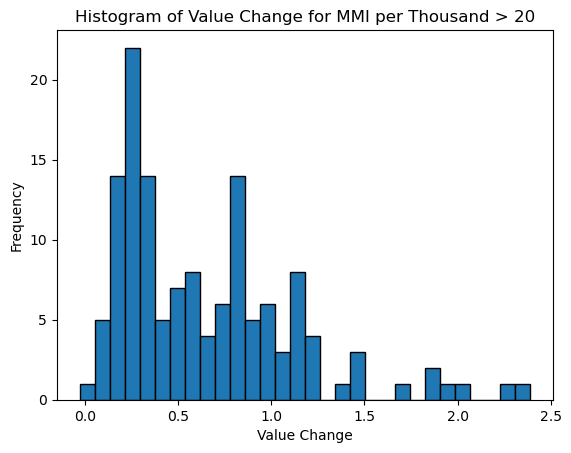

In [429]:
# Filter the data where mmi_per_thousand is greater than 20
filtered_data_high_mmi = filtered_data[filtered_data['mmi_per_thousand'] > 20]

# Plot the histogram of value_change
plt.hist(filtered_data_high_mmi['value_change'], bins=30, edgecolor='black')
plt.xlabel('Value Change')
plt.ylabel('Frequency')
plt.title('Histogram of Value Change for MMI per Thousand > 20')
plt.show()

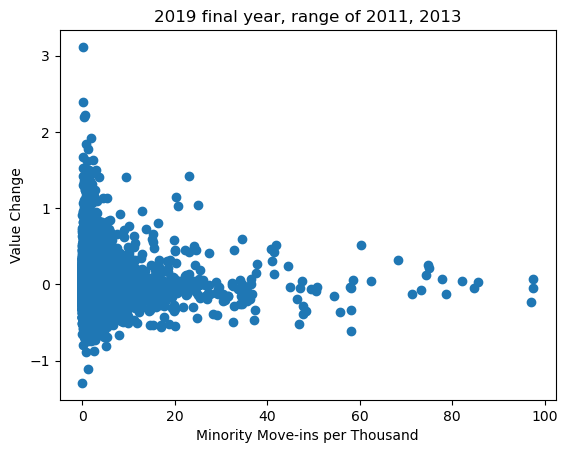

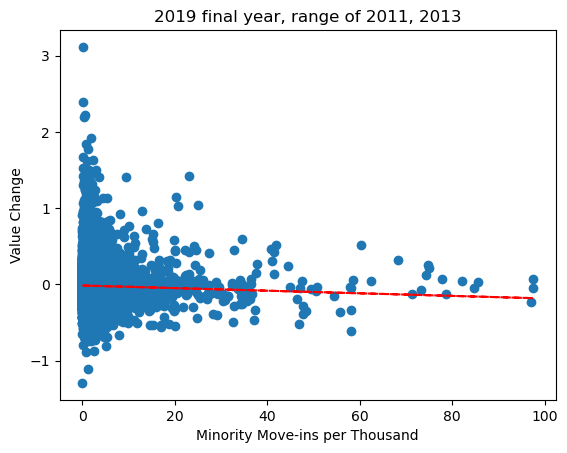

In [430]:
filtered_data = data_table[(data_table['mmi_per_thousand'].abs() < 100)]
plt.scatter(filtered_data['mmi_per_thousand'], filtered_data['change_from_metro'])
plt.xlabel('Minority Move-ins per Thousand')
plt.ylabel('Value Change')
plt.title(f'{final} final year, range of {loan_start}, {loan_end}')
plt.show()

# Remove NaN values
filtered_data_clean = filtered_data.dropna(subset=['mmi_per_thousand', 'change_from_metro'])
# Plot the scatter plot again
plt.scatter(filtered_data_clean['mmi_per_thousand'], filtered_data_clean['change_from_metro'])
plt.xlabel('Minority Move-ins per Thousand')
plt.ylabel('Value Change')
plt.title(f'{final} final year, range of {loan_start}, {loan_end}')

# Plot the trendline
plt.plot(filtered_data_clean['mmi_per_thousand'], p(filtered_data_clean['mmi_per_thousand']), "r--")
plt.show()

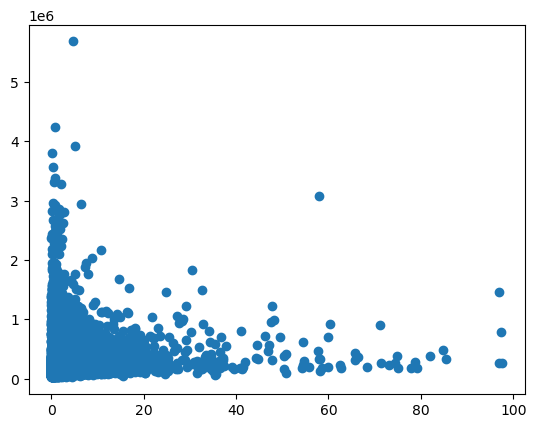

In [431]:
filtered_data = data_table[(data_table['mmi_per_thousand'].abs() < 100)]
plt.scatter(filtered_data['mmi_per_thousand'], filtered_data['avg_value_2023'])
plt.show()

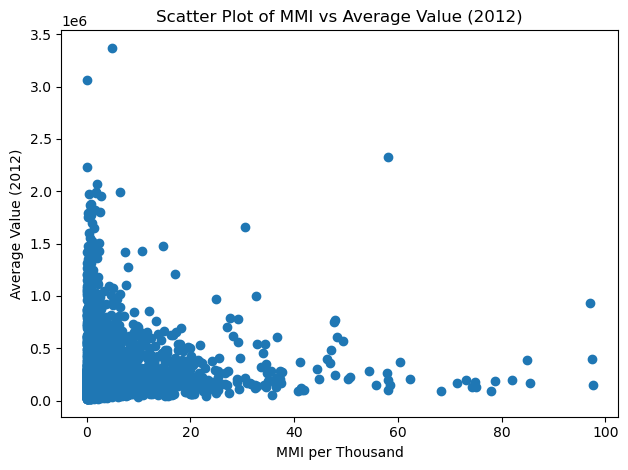

In [432]:
filtered_data = data_table[(data_table['mmi_per_thousand'].abs() < 100)]
plt.scatter(filtered_data['mmi_per_thousand'], filtered_data['avg_value_2012'])
plt.xlabel('MMI per Thousand')
plt.ylabel('Average Value (2012)')
plt.title('Scatter Plot of MMI vs Average Value (2012)')
plt.tight_layout()
plt.show()

## Conclusion

## References

Manson, S., Schroeder, J., Van Riper, D., Knowles, K., Kugler, T., Roberts, F., & Ruggles, S. (2024). *National Historical Geographic Information System: Version 19.0* [Dataset]. Minneapolis, MN: IPUMS. https://doi.org/10.18128/D050.V19.0